## Notes
### 6/18/20
- Value of unity should just mean one, which is good.
- Set up code for two parameterizations of charge generation + seperation, the first being noninductive and the second being inductive, which together should account for almost all charge. It'll also be interesting to see how much the inductive process contributes, since it's not really considered that important, yet still important enough to include here.
- Had to search around to figure out what constants were in the equations and finding their exact values. Still a few to go.


### 6/22/20
- Since these differential equations are dependent on time, it may not be necessary to solve complete solve them. When model is working, hopefully there is a sign reversal between -10 and -21 degrees C.
- Their expression for temperature is weirdly complicated, but since I'm only doing a one-dimensional model, mine can be simpler. It's F(tau)= a tau^3 + b tau^2 + c tau + d, where tau = (-21/T_r)(T-273.16) and T_r = -21 or T_r = -10. This implies a conversion to Kelvin. I'll stick with my current temperature function, and if it doesn't work, then I'll try incorporating their stuff.

### 6/23/20
- Found graupel drag coefficient from the book: Parameterization Schemes: Keys to Understanding Numerical Weather Prediction by Stensrud.
- Looked around to find what the intercept parameters for graupel and snow are, which turns on you need a distribution describing their size. Lambda (I used Y_g) is the slope, which is apparently almost never constant. However, the textbook that explained it (Storm and Cloud Dynamics, Cotton & Anthes) pretended the slope was constant for their example, and in some cases it kind of it, so I will just make it constant.
- How to even know what that constant is? Cotton & Anthes gave the equation: $Y_g = 2.67 * 10^3 * M_g^{-1/3}$. M_g stands for graupel water content, so I searched for what value that might be. Turns out it usually is around 0.5, 1, or 2 g m^-3. Since 1 seems like a simple, midrange option, that's what I'm going with.
- But what about the intercept parameter? According to paper Diagnosing the Intercept Parameter for Exponential Raindrop Size Distribution Based on Video Disdrometer Observations: Model Development (Zhang 2008), the most common value for $n_{0g} = 8 \times 10^6$ m^-4. Another weird unit in meteorology that I'm sure makes sense but is still strange.
- The Zhang 2008 paper has a really nice graph showing the dropsize distribution vs diameter. The range of diameter for graupel is 0 to 5 mm, so I think I'm going to make an array of those values for the graupel distribution.
- This doesn't give me exact distibution I think is ideal, which starts which a good amount of graupel near 0, then peaks at around 1, and slowly goes decreases until it's nearly zero at 5. However, I do have the a lot of 0 mm graupel, and it does go to nearly zero around 5 mm, so it's not awful.

### 6/25/20
- I don't know how I'm going to deal with $ \rho_a$, the air density at altitude. Obviously altitude is changing. So that's probably going to be an array, and the charge separation equation will give something for every air density in the array. Which I think is what I want, something that describes the charge changing as altitude changes. 
- Found this familiar equation: $\rho = \frac{\rho_0 M}{RT_0}(1 - \frac{Lh}{T_0})^{gM/RL-1}$. That'll be my model for how air density changes with altitude, which is $h$. The rest is easy. Wel'll pretend it's 297 K out (it should be at least pretty warm if there are going to be thunderstorms)
- Density function was being weird, so moved it up my code by altitude. Also had desnity increasing with altitude for a little while was bad, but that was just due to misplaced parenthesis and is fixed.
- Did some dimensional analysis to check the density units I get, which are kg/m^3, which is good.
- Changed N_1 to N_i, misread blurry PDF paper. Double checking  values for P_l (where did 300 come from again?) and finding N_i are what's necessary next.

### 6/29/20
- Checked the value for P_l (graupel density) again. According to the Handbook of Atmospheric Electrodynamics (Volland 1995) and confirmed by other sources, graupel density in thunderstorms range from 0.1 to 1.0 gm/cm^3. If I go with an average-ish of 0.5, that means it's $500 \mathrm{kg/m^3}$, which is the same magnitude as 300, so I guess my original value was that off. However, that still seems like a really high density.
- For N_i, the number seems to vary widely, from 10^2 to 10^6 ice crystals/liter, with amounts usually around 10^4/L, so I'll try that. Have to convert per L to per m^3 though,  which means it's $10^7 \mathrm{m^{-3}}$.
- And fortunately when I put the numbers in the equation, it works, but I don't think I'm at the point where it's actually meaningful yet. I plotted the array, but it automatically does it versus density, which isn't what I want.
- Changed it to versus Z. 

### 6/30/20
- Air density is fixed. It was a really stupid mistake. But now it's right, and I confirmed it with other sources.
- This is minor, but I also realized it would make a lot more sense if I moved notes to the top of the document instead of the middle.
- Back to the whole graupel density thing. In another diagnosis paper, Incorporating Diagnosed Intercept Parameters... (Pan 2016), it mentioned graupel particle density as $400 \: \mathrm{kg/m^3}$. Maybe we feel slightly better about this since the density of air is not longer $300 \: \mathrm{kg/m^3}$. 
- All graphs have labels and titles now. 
- Was looking at my graupel distribution plot with its newly correct x-axis and compared it to Zhang 2008. They looked unsettlingly different, but then I realized theirs had log scale, so I put a logscale on my, and everything looks good now.

### 7/1/20
- Looked for papers that calculated amount of charge generated like my final result. The closest thing I've seen is in Mansell 2010 $ \mathrm{C \: minute^{-1} \: level^{-1}} $ in which their volume was a level, which was 125 m thick. However, it was a 2D model, and I'm not entirely sure what length they used. The charge varied horizontally across the level, so I'm assuming it was parametrized, but as there was no horizontal scale, there's not much I can gather from it.  Basically, the problem is that other models are so much more complex than mine that I don't even know how to compare results. I've looked through five other papers and haven't seen anything helpful, so I could keep looking, or I could just continue with my model.
- Ziegler (1991) has nC/m^3, which is also close to mine, but I'm not sure what time it's over, and it's also 2D, so I don't know how I work compare mine.
- The next step is adding in the charge magnitude, which I'm not entirely sure how to do that. But I could have it correspond to temperture, and some assign a range of temperature to be positive and negative. How I will actually do that is for another day.

In [93]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [94]:
#Altitude in km
z = linspace(0,10,21)

In [95]:
#air density kg/m^3
p_a = ((101325*0.0289654)/(8.31447*288.15))*(1-(0.0065*z*1000)/297)**(9.8*0.028964/(8.31447*0.0065)-1)

Text(0.5, 1.0, 'Altitude vs. Air Density')

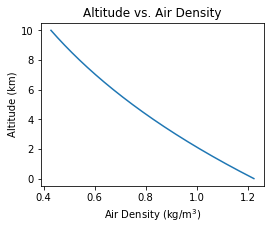

In [99]:
plot(p_a,z)
xlabel('Air Density ($\mathrm{kg/m^3}$)')
ylabel('Altitude (km)')
title('Altitude vs. Air Density')

Change in temperature is the environmental lapse rate, which can be derived from IGL, but in thunderstorms, the air isn't dry, so it doesn't apply. I looked up the average lapse rate to be 6.5 degrees C / km, which isn't perfect, but better than assuming temperature is constant. Assuming it's a warm day, we'll start at ground level at 25 degrees C.

In [100]:
#Temperature
T = 25 - z*6.5

Text(0.5, 1.0, 'Temperature vs. Altitude')

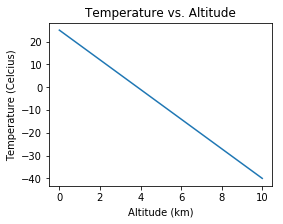

In [101]:
plot(z,T)
ylabel('Temperature (Celcius)')
xlabel('Altitude (km)')
title('Temperature vs. Altitude')

In [102]:
#constants
g = 9.8                     #easy m/s^2
P_l = 300                   #density of graupel kg/m^3
C_D = 0.6                   #graupel drag coefficient
E_gi = 1                    #value of unity ? product of collision effiency and rebound efficiency 
dq = 10**(-16)              #C/collision
N_i = 10**7                 #ice crystal concentration per m^3
n_0g = 1.95E7*.5            #intercept parameters of graupel and snow distributions
Y_g = 2.67E3                #graupel slope parameter (/m)
D = linspace(0,.007,29)     #diameter of graupel in m

Text(0.5, 1.0, 'Graupel Distribution')

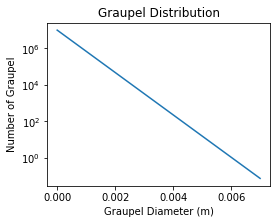

In [105]:
#graupel distribution
n = n_0g * exp(-Y_g * D)

plot(D,n)
yscale("log")
xlabel('Graupel Diameter (m)')
ylabel('Number of Graupel')
title('Graupel Distribution')

In [60]:
#the noninductive charge generation equation for graupel & ice
#all in MKS units
C = 2.61 * (4 * g * P_l / (3 * C_D * p_a))**(1/2) * E_gi * dq * N_i * n_0g * Y_g**(-3.5)
C

array([1.88952065e-12, 1.93424390e-12, 1.98054112e-12, 2.02848623e-12,
       2.07815755e-12, 2.12963807e-12, 2.18301579e-12, 2.23838409e-12,
       2.29584213e-12, 2.35549529e-12, 2.41745561e-12, 2.48184236e-12,
       2.54878254e-12, 2.61841152e-12, 2.69087371e-12, 2.76632326e-12,
       2.84492491e-12, 2.92685482e-12, 3.01230155e-12, 3.10146713e-12,
       3.19456818e-12])

Text(0.5, 1.0, 'Charge Generation')

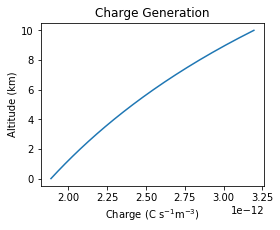

In [104]:
plot(C,z)
xlabel('Charge (C $\mathrm{s^{-1} m^{-3}}$)')
ylabel('Altitude (km)')
title('Charge Generation')

____________________________________________________________________

In [ ]:
dV =                        #difference in sedimentation speeds for different hydrometeors
dL =                        #function of cloud water content
beta = T                    #temperature function
d = 0.0002                  #diameter of cloud droplet
E_gc = .01 * exp(.01*T)     #graupel-droplet collision efficiency
n_c =                       #numerical concentration of hydrometeors
alpha = 0.022                #rebound probability and droplets w/ grazing trajectories
e = 1.0005898                 #dielectric permittivity of air
cos = 0.84                   #cosine of angle between cloud droplet and graupel
E_r = 0.1                    #probility of cloud droplet collision
E_z =                       #vertical eletric field in thunderstorm
Q_d = p_g/N_g                       #individual charge. N_g is graupel concentration
V_D =                        # fall speed 
#the inductive charge generation equation
S = pi / 4 * E_gc * E_r * D**2 * V_D * n_c * alpha * ((pi**3 / 2) * (d)**2 * e * E_z * cos - (pi**2/6 * Q_d * d**2 / D**2))